# Arquitetura do Modelo 2

## Etapa 1 - Importando as bibliotecas

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import zipfile

cv2.__version__

'4.1.2'

In [1]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.7.0'

## Etapa 2 - Conectando com o Drive e acessando os arquivos

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
path = "/content/gdrive/My Drive/Material.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("./")
base_imgs = 'Material/fer2013.zip'
zip_object = zipfile.ZipFile(file = base_imgs, mode = "r")
zip_object.extractall("./new_new_fer2013")
zip_object.close()

Mounted at /content/gdrive


## Etapa 3 - Acessando a base com fotos de expressões faciais



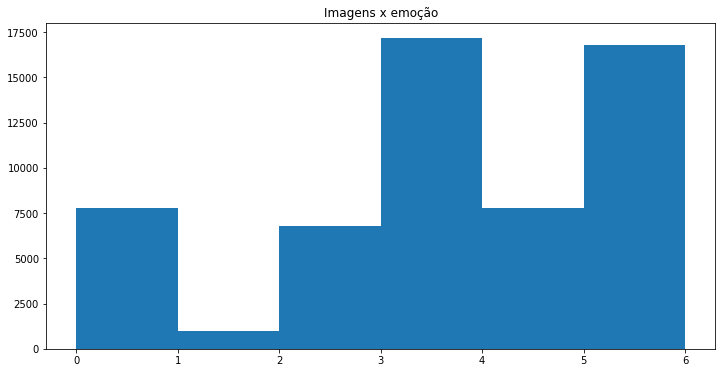

In [ ]:
data = pd.read_csv('new_new_fer2013/fer2013/fer2013.csv')
plt.figure(figsize=(12,6))
plt.hist(data['emotion'], bins=6)
plt.title("Imagens x emoção")
plt.show()

# Classes: ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

## Etapa 4 - Pré-processamento

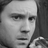

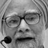

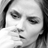

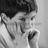

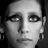

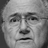

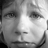

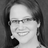

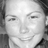

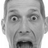

In [ ]:
pixels = data['pixels'].tolist()
largura, altura = 48, 48

faces = []
amostras = 0 
for pixel_sequence in pixels:
  face = [int(pixel) for pixel in pixel_sequence.split(' ')]
  face = np.asarray(face).reshape(largura, altura) 
  faces.append(face)
  
  if (amostras < 10):
    cv2_imshow(face)

  amostras = amostras + 1

faces = np.asarray(faces) 
faces = np.expand_dims(faces, -1)

def normalizar(x):
    x = x.astype('float32')
    x = x / 255.0
    return x

faces = normalizar(faces)

emocoes = pd.get_dummies(data['emotion']).values

In [ ]:
print("Número total de imagens no dataset: "+str(len(faces)))

Número total de imagens no dataset: 57237


## Etapa 5 - Imports do Tensorflow/Keras

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

## Etapa 6 - Dividir em conjuntos para treinamento e validação

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(faces, emocoes, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=41)

print("Número de imagens no conjunto de treinamento:", len(x_train))
print("Número de imagens no conjunto de testes:", len(x_test))
print("Número de imagens no conjunto de validação:", len(y_val))

Número de imagens no conjunto de treinamento: 46361
Número de imagens no conjunto de testes: 5724
Número de imagens no conjunto de validação: 5152


In [ ]:
np.save('mod_xtest2', x_test)
np.save('mod_ytest2', y_test)

## Etapa 7 - Arquitetura do Modelo (CNN)

### Arquitetura do modelo

Implementação original: https://github.com/rajeevratan84/DeepLearningCV/blob/master/18.2%20Building%20an%20Emotion%20Detector%20with%20LittleVGG.ipynb

In [ ]:
num_features = 32
num_classes = 7
width, height = 48, 48
batch_size = 16
epochs = 100

model = Sequential()

model.add(Conv2D(num_features, (3, 3), padding = 'same', kernel_initializer="he_normal",
                 input_shape = (width, height, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(num_features, (3, 3), padding = "same", kernel_initializer="he_normal", 
                 input_shape = (width, height, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(2*num_features, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(2*2*num_features, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(2*2*2*num_features, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(2*num_features, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2*num_features, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes, kernel_initializer="he_normal"))
model.add(Activation("softmax"))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                        

## Etapa 8 - Compilando o modelo 

In [ ]:
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])
arquivo_modelo = "modelo_06_expressoesVGG.h5" # arquivo do modelo
arquivo_modelo_json = "modelo_06_expressoesVGG.json" # arquivo do json, para salvar a arquitetura
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(arquivo_modelo, monitor='val_loss', verbose=1, save_best_only=True)

### Salvando a arquitetura do modelo em um arquivo JSON

In [ ]:
model_json = model.to_json()
with open(arquivo_modelo_json, "w") as json_file:
    json_file.write(model_json)

## Etapa 9 - Treinando o modelo

In [ ]:
history = model.fit(np.array(x_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(x_val), np.array(y_val)),
          shuffle=True,
          callbacks=[lr_reducer, early_stopper, checkpointer])

Epoch 1/100
2898/2898 [==============================] - ETA: 0s - loss: 1.6475 - accuracy: 0.3936
Epoch 00001: val_loss improved from inf to 1.26200, saving model to modelo_06_expressoesVGG.h5
2898/2898 [==============================] - 94s 29ms/step - loss: 1.6475 - accuracy: 0.3936 - val_loss: 1.2620 - val_accuracy: 0.5124 - lr: 0.0010
Epoch 2/100
2897/2898 [============================>.] - ETA: 0s - loss: 1.2306 - accuracy: 0.5444
Epoch 00002: val_loss improved from 1.26200 to 1.07942, saving model to modelo_06_expressoesVGG.h5
2898/2898 [==============================] - 79s 27ms/step - loss: 1.2305 - accuracy: 0.5445 - val_loss: 1.0794 - val_accuracy: 0.5924 - lr: 0.0010
Epoch 3/100
2897/2898 [============================>.] - ETA: 0s - loss: 1.1126 - accuracy: 0.5954
Epoch 00003: val_loss improved from 1.07942 to 0.99305, saving model to modelo_06_expressoesVGG.h5
2898/2898 [==============================] - 79s 27ms/step - loss: 1.1126 - accuracy: 0.5954 - val_loss: 0.9931 - 

## Gerando gráfico da melhora em cada etapa do treinamento

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


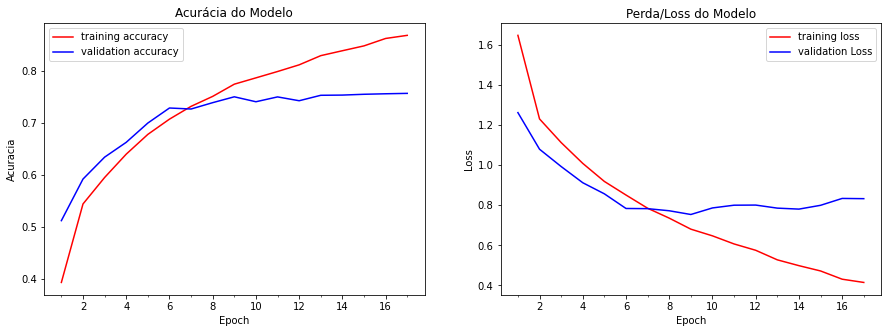

In [ ]:
def plota_historico_modelo(historico_modelo):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(historico_modelo.history['accuracy'])+1),
                historico_modelo.history['accuracy'],'r')
    axs[0].plot(range(1,len(historico_modelo.history['val_accuracy'])+1),
                historico_modelo.history['val_accuracy'],'b')
    axs[0].set_title('Acurácia do Modelo')
    axs[0].set_ylabel('Acuracia')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(historico_modelo.history['accuracy'])+1),
                      len(historico_modelo.history['accuracy'])/10)
    axs[0].legend(['training accuracy', 'validation accuracy'], loc='best')

    axs[1].plot(range(1,len(historico_modelo.history['loss'])+1),
                historico_modelo.history['loss'],'r')
    axs[1].plot(range(1,len(historico_modelo.history['val_loss'])+1),
                historico_modelo.history['val_loss'],'b')
    axs[1].set_title('Perda/Loss do Modelo')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(historico_modelo.history['loss'])+1),
                      len(historico_modelo.history['loss'])/10)
    axs[1].legend(['training loss', 'validation Loss'], loc='best')
    fig.savefig('historico_modelo_mod01.png')
    plt.show()

plota_historico_modelo(history)

### Verificando a acurácia do modelo

In [ ]:
scores = model.evaluate(np.array(x_test), np.array(y_test), batch_size=batch_size)
print("Acurácia: " + str(scores[1]))
print("Perda/Loss: " + str(scores[0]))

358/358 [==============================] - 5s 14ms/step - loss: 0.7772 - accuracy: 0.7680
Acurácia: 0.7679944038391113
Perda/Loss: 0.7771991491317749


## Carregaremos os dados para gerar a matriz de confusão

In [ ]:
true_y=[]
pred_y=[]
x = np.load('mod_xtest2.npy')
y = np.load('mod_ytest2.npy')
json_file = open(arquivo_modelo_json, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(arquivo_modelo)
y_pred= loaded_model.predict(x)
yp = y_pred.tolist()
yt = y.tolist()
count = 0
for i in range(len(y)):
    yy = max(yp[i])
    yyt = max(yt[i])
    pred_y.append(yp[i].index(yy))
    true_y.append(yt[i].index(yyt))
    if(yp[i].index(yy)== yt[i].index(yyt)):
        count+=1
acc = (count/len(y))*100
np.save('truey__mod01', true_y)
np.save('predy__mod01', pred_y)
print("Acurácia no conjunto de testes: "+str(acc)+"%")

Acurácia no conjunto de testes: 75.40181691125088%


## Gerando a Matriz de Confusão

In [ ]:
from sklearn.metrics import confusion_matrix
y_true = np.load('truey__mod01.npy')
y_pred = np.load('predy__mod01.npy')
cm = confusion_matrix(y_true, y_pred)
expressoes = ["Raiva", "Nojo", "Medo", "Feliz", "Triste", "Surpreso", "Neutro"]
titulo='Matriz de Confusão'
print(cm)

[[ 535    6   49   29   88   21   54]
 [  22   66    7    3    4    1    0]
 [  73    4  332   25  115   76   41]
 [  18    0   22 1557   39   21   39]
 [  73    0   75   44  486   12  113]
 [  11    0   26   19    7  497   14]
 [  48    0   39   42  117   11  843]]


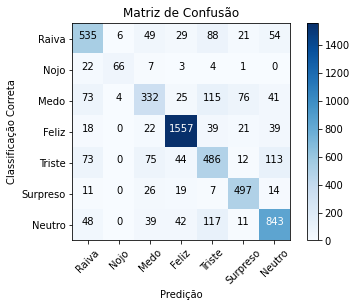

In [ ]:
import itertools
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(titulo)
plt.colorbar()
tick_marks = np.arange(len(expressoes))
plt.xticks(tick_marks, expressoes, rotation=45)
plt.yticks(tick_marks, expressoes)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classificação Correta')
plt.xlabel('Predição')
plt.savefig('matriz_confusao_mod01.png')
plt.show()

## Testando brevemente o modelo

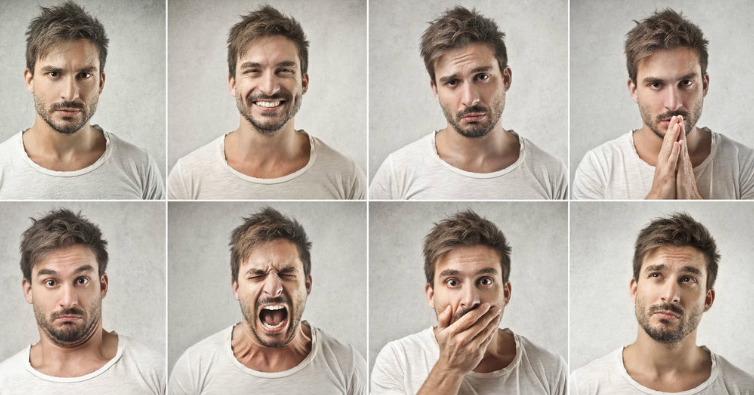

In [ ]:
imagem = cv2.imread("Material/testes/teste02.jpg")
cv2_imshow(imagem)

In [ ]:
model = load_model("modelo_06_expressoesVGG.h5")
scores = model.evaluate(np.array(x_test), np.array(y_test), batch_size=batch_size)
print("Perda/Loss: " + str(scores[0]))
print("Acurácia: " + str(scores[1]))

225/225 [==============================] - 3s 13ms/step - loss: 1.0384 - accuracy: 0.6283
Perda/Loss: 1.038372278213501
Acurácia: 0.6283087134361267


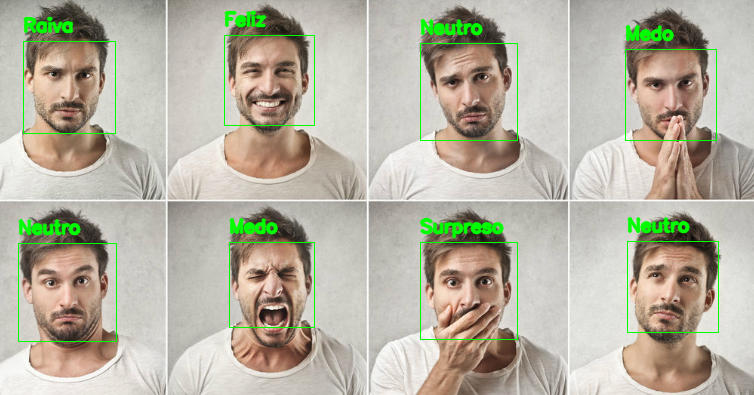

In [ ]:
expressoes = ["Raiva", "Nojo", "Medo", "Feliz", "Triste", "Surpreso", "Neutro"]
original = imagem.copy()
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
face_cascade = cv2.CascadeClassifier('Material/haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, 1.1, 3)
for (x, y, w, h) in faces:
    cv2.rectangle(original, (x, y), (x + w, y + h), (0, 255, 0), 1)
    roi_gray = gray[y:y + h, x:x + w]
    roi_gray = roi_gray.astype("float") / 255.0
    cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
    cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, 
                  norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
    prediction = model.predict(cropped_img)[0]
    cv2.putText(original, expressoes[int(np.argmax(prediction))], (x, y - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)
cv2_imshow(original)